In [2]:
import pygraphviz as pgv
from IPython.core.display import Image

## The cell below comes from the Orthology notebook

In [3]:
import requests
 
ensembl_server = 'http://rest.ensembl.org'

def do_request(server, service, *args, **kwargs):
    params = ''
    for a in args:
        if a is not None:
            params += '/' + a
    req = requests.get('%s/%s%s' % (server, service, params),
                       params=kwargs,
                       headers={'Content-Type': 'application/json'})
 
    if not req.ok:
        req.raise_for_status()
    return req.json()

In [4]:
lct_id = 'ENSG00000115850'

In [5]:
refs = do_request(ensembl_server, 'xrefs/id', lct_id, external_db='GO', all_levels='1')
print(len(refs))
print(refs[0].keys())
for ref in refs:
    go_id = ref['primary_id']
    details = do_request(ensembl_server, 'ontology/id', go_id)
    print('%s %s %s' % (go_id,  details['namespace'], ref['description']))
    print('%s\n' % details['definition'])

27
[u'display_id', u'description', u'db_display_name', u'info_text', u'linkage_types', u'info_type', u'primary_id', u'synonyms', u'version', u'dbname']
GO:0000016 molecular_function lactase activity
"Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose." [EC:3.2.1.108]

GO:0000016 molecular_function lactase activity
"Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose." [EC:3.2.1.108]

GO:0001666 biological_process response to hypoxia
"Any process that results in a change in state or activity of a cell or an organism (in terms of movement, secretion, enzyme production, gene expression, etc.) as a result of a stimulus indicating lowered oxygen tension. Hypoxia, defined as a decline in O2 levels below normoxic levels of 20.8 - 20.95%, results in metabolic adaptation at both the cellular and organismal level." [GOC:hjd]

GO:0004553 molecular_function hydrolase activity, hydrolyzing O-glycosyl compounds
"Catalysis of the hydrolysis of any O-glycosyl bond." [GOC

GO id로 검색

In [6]:
go_id = 'GO:0000016'
my_data = do_request(ensembl_server, 'ontology/id', go_id)
for k, v in my_data.items():
    if k == 'parents':
        for parent in v:
            print(parent)
            parent_id = parent['accession']
    else:
        print('%s: %s' % (k, str(v)))

parent_data = do_request(ensembl_server, 'ontology/id', parent_id)
print(parent_id, len(parent_data['children']))

definition: "Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose." [EC:3.2.1.108]
name: lactase activity
subsets: []
namespace: molecular_function
accession: GO:0000016
synonyms: [u'"lactase-phlorizin hydrolase activity" [EC:3.2.1.108]', u'"lactose galactohydrolase activity" [EC:3.2.1.108]']
{u'definition': u'"Catalysis of the hydrolysis of any O-glycosyl bond." [GOC:mah]', u'name': u'hydrolase activity, hydrolyzing O-glycosyl compounds', u'subsets': [u'gosubset_prok'], u'namespace': u'molecular_function', u'accession': u'GO:0004553', u'synonyms': [u'"O-glucosyl hydrolase activity" []'], u'ontology': u'GO'}
ontology: GO
children: []
(u'GO:0004553', 97)


상위 기능 검색

In [6]:
refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)
for go, entry in refs.items():
    print(go)
    term = entry['term']
    print('%s %s' % (term['name'], term['definition']))
    is_a = entry.get('is_a', [])
    print('\t is a: %s\n' % ', '.join([x['accession'] for x in is_a]))


GO:0016787
hydrolase activity "Catalysis of the hydrolysis of various bonds, e.g. C-O, C-N, C-C, phosphoric anhydride bonds, etc. Hydrolase is the systematic name for any enzyme of EC class 3." [ISBN:0198506732]
	 is a: GO:0003824

GO:0000016
lactase activity "Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose." [EC:3.2.1.108]
	 is a: GO:0004553

GO:0016798
hydrolase activity, acting on glycosyl bonds "Catalysis of the hydrolysis of any glycosyl bond." [GOC:jl]
	 is a: GO:0016787

GO:0003824
catalytic activity "Catalysis of a biochemical reaction at physiological temperatures. In biologically catalyzed reactions, the reactants are known as substrates, and the catalysts are naturally occurring macromolecular substances known as enzymes. Enzymes possess specific binding sites for substrates, and are usually composed wholly or largely of protein, but RNA that has catalytic activity (ribozyme) is often also regarded as enzymatic." [ISBN:0198506732]
	 is a: GO:0003674

GO:00

## 상위 기능 찾는 function

In [8]:
def get_upper(go_id):
    parents = {}
    node_data = {}
    refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)
    for ref, entry in refs.items():
        my_data = do_request(ensembl_server, 'ontology/id', ref)
        node_data[ref] = {'name': entry['term']['name'], 'children': my_data['children']}
        try:
            parents[ref] = [x['accession'] for x in entry['is_a']]
        except KeyError:
            pass  # Top of hierarchy
    return parents, node_data

In [9]:
parents, node_data = get_upper(go_id)

strict digraph {
	"catalytic activity
(GO:0003824)" -> "...26...";
	"catalytic activity
(GO:0003824)" -> "hydrolase activity
(GO:0016787)";
	"hydrolase activity
(GO:0016787)" -> "hydrolase activity
acting on glycosyl bonds
(GO:0016798)";
	"hydrolase activity
(GO:0016787)" -> "...22...";
	"hydrolase activity
acting on glycosyl bonds
(GO:0016798)" -> "GO:0016799";
	"hydrolase activity
acting on glycosyl bonds
(GO:0016798)" -> "hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)";
	"hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)" -> "...96...";
	"hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)" -> "lactase activity
(GO:0000016)";
	"molecular_function
(GO:0003674)" -> "catalytic activity
(GO:0003824)";
	"molecular_function
(GO:0003674)" -> "...17...";
}



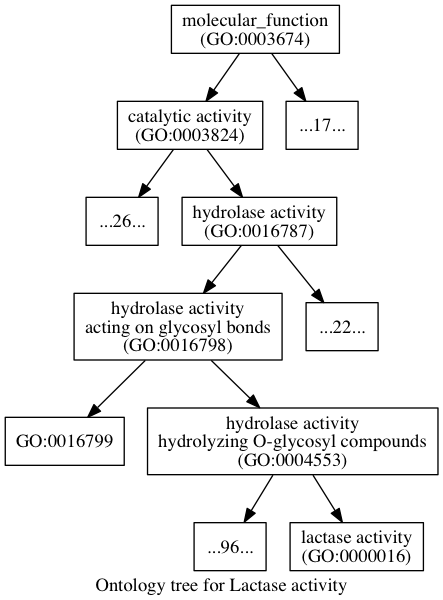

In [10]:
g = pgv.AGraph(directed=True)
for ofs, ofs_parents in parents.items():
    ofs_text = '%s\n(%s)' % (node_data[ofs]['name'].replace(', ', '\n'), ofs)
    for parent in ofs_parents:
        parent_text = '%s\n(%s)' % (node_data[parent]['name'].replace(', ', '\n'), parent)
        children = node_data[parent]['children']
        if len(children) < 3:
            for child in children:
                if child['accession'] in node_data:
                    continue
                g.add_edge(parent_text, child['accession'])
        else:
            g.add_edge(parent_text, '...%d...' % (len(children) - 1))
        g.add_edge(parent_text, ofs_text)
print(g)
g.graph_attr['label']='Ontology tree for Lactase activity'
g.node_attr['shape']='rectangle'
g.layout(prog='dot')
g.draw('graph.png')
Image("graph.png")

In [11]:
print(go_id)
refs = do_request(ensembl_server, 'ontology/descendants', go_id)
for go in refs:
    print(go['accession'], go['name'], go['definition'])

GO:0000016
(u'GO:0004553', u'hydrolase activity, hydrolyzing O-glycosyl compounds', u'"Catalysis of the hydrolysis of any O-glycosyl bond." [GOC:mah]')
(u'GO:0016798', u'hydrolase activity, acting on glycosyl bonds', u'"Catalysis of the hydrolysis of any glycosyl bond." [GOC:jl]')
(u'GO:0016787', u'hydrolase activity', u'"Catalysis of the hydrolysis of various bonds, e.g. C-O, C-N, C-C, phosphoric anhydride bonds, etc. Hydrolase is the systematic name for any enzyme of EC class 3." [ISBN:0198506732]')
(u'GO:0003824', u'catalytic activity', u'"Catalysis of a biochemical reaction at physiological temperatures. In biologically catalyzed reactions, the reactants are known as substrates, and the catalysts are naturally occurring macromolecular substances known as enzymes. Enzymes possess specific binding sites for substrates, and are usually composed wholly or largely of protein, but RNA that has catalytic activity (ribozyme) is often also regarded as enzymatic." [ISBN:0198506732]')
(u'GO:0